In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools as it

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression
import warnings
np.warnings.filterwarnings('ignore')

In [3]:
# Loading test and train data
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [4]:
# Separate into test and train
y_train = train.target
X_train = train.drop("target", axis = 1)

y_test = test.target
X_test = test.drop('target', axis = 1)

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [5]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train_columns)

In [6]:
# Model without any restrictions
model = DecisionTreeClassifier(random_state = 1)

# Compute the pruning path during Minimal Cost-Complexity Pruning
path= model.cost_complexity_pruning_path(X_train,y_train)

In [7]:
alphas=path['ccp_alphas']

In [8]:
len(alphas)

232

In [9]:
# Finding cross-validation error for trees
param_grid = {    
    'max_depth': range(0, 50),
    'max_leaf_nodes': range(0, 50),
    'max_features': range(1, 50),
    'ccp_alpha':alphas
}

cv = StratifiedKFold(n_splits=5)

grid_search_model = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), param_distributions = param_grid, 
                                       scoring = ['accuracy', 'recall'], refit = 'recall', n_jobs=-1, verbose=True,
                                       cv=cv, n_iter = 1000)

grid_search_model.fit(X_train, y_train)

# make the predictions
y_pred = grid_search_model.predict(X_test)

print('Train accuracy : %.3f'%grid_search_model.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search_model.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search_model.best_score_)

print('Best params for recall')
print(grid_search_model.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Train accuracy : 0.854
Test accuracy : 0.804
Best accuracy Through Grid Search : 0.775
Best params for recall
{'max_leaf_nodes': 8, 'max_features': 40, 'max_depth': 15, 'ccp_alpha': 0.000190909090909091}


In [10]:
tree = DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=8, max_features=40, 
                              ccp_alpha = 0.000190909090909091).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=8, 
                                                           max_features=40, ccp_alpha = 0.000190909090909091), 
                                    X_train, y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

In [12]:
metrics.loc[(metrics.accuracy>=80) & (metrics.recall>80), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.171000
accuracy     80.960000
recall       86.486486
Name: 171, dtype: float64

In [13]:
metrics.loc[(metrics.accuracy>=80) & (metrics.recall>80), :].sort_values(by = 'accuracy', ascending = False).iloc[0,:]

threshold     0.23800
accuracy     82.74000
recall       82.13866
Name: 238, dtype: float64

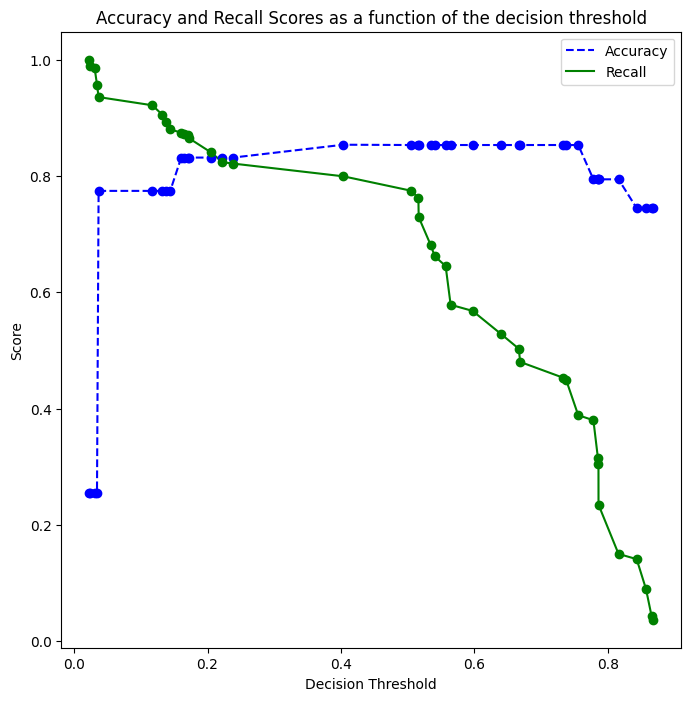

In [14]:
tree = DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=8, max_features=40, 
                              ccp_alpha = 0.000190909090909091)

cross_val_ypred = cross_val_predict(tree, X_train, y_train, cv = 5, method = 'predict_proba')

tree.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

for t in thresholds:
  y_pred_prob = tree.predict_proba(X_train)[:,1]
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

### **Maximal Recall Model**

Accuracy:  83.17
ROC-AUC:  0.8928515656086139
Precision:  0.6216442953020134
Recall:  0.8707403055229143


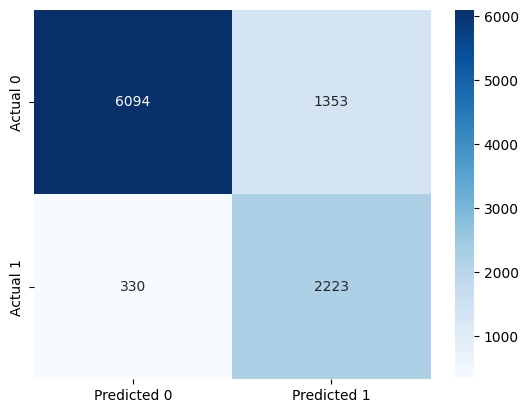

In [15]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.171000

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  80.03
ROC-AUC:  0.8426389502530497
Precision:  0.6192492238216201
Recall:  0.7719915552427867


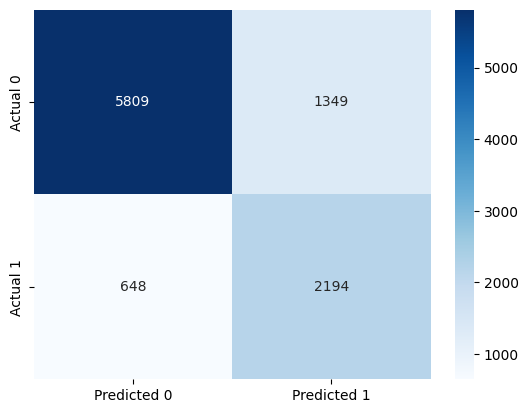

In [16]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.171000

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### **Maximal Accuracy Model**

Accuracy:  83.17
ROC-AUC:  0.8928515656086139
Precision:  0.6216442953020134
Recall:  0.8707403055229143


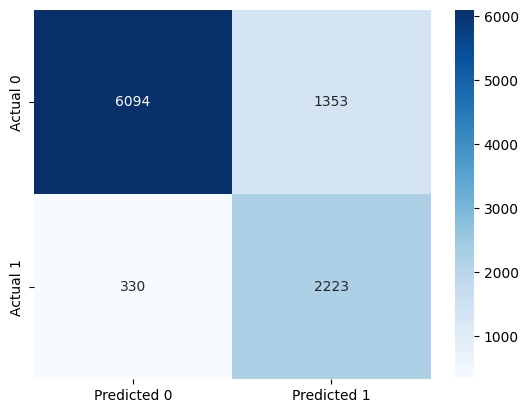

In [17]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.23800

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  80.03
ROC-AUC:  0.8426389502530497
Precision:  0.6192492238216201
Recall:  0.7719915552427867


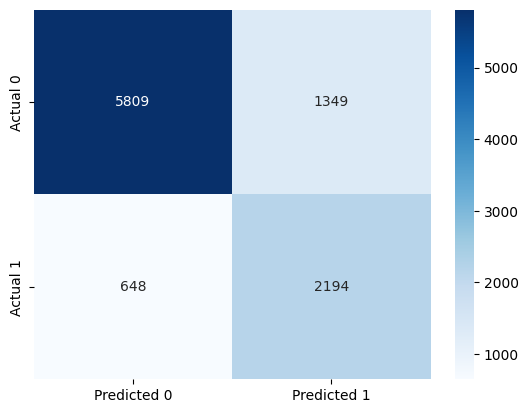

In [18]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.23800

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');